In [41]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap

In [42]:
#dfStats = gp.read_file("regression_results/ols_run_tdx2.gpkg")
#dfStats = gp.read_file("regression_results/test.gpkg")
#rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
#countries = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/countries.shp")
coastline = gp.read_file('/data/puma1/scratch/mtngla/background-shapefiles/alaska/coastline.shp')
#glaciers = gp.read_file("/data/puma1/scratch/mtngla/masks/alaska/glacier/PCR-glacier-outlines.shp")

In [43]:
environmentName = 'DEVv2'
# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
dataset = 'ReadyDataAlaska2'
runName='AlaskaRun2'
region='alaska'
size = 100000

query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

bbx = query.getDataSetBoundingBox( parentDsName, dataset, region)
bbx = json.loads(bbx)
minT = datetime.datetime.utcfromtimestamp(bbx['minTime'])
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":-3900000,"gridCellMaxX":-2700000,"gridCellMinY":-700000,"gridCellMaxY":1500000,"minTime":1279277354,"maxTime":1556392162,"totalPoints":21186351,"numberOfShards":104}


In [44]:
stats = query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.ADwithTDX_filtered,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsOnDataSetValue0,statistics.pointsOnDataSetValue0Ratio,...,statistics.result_refDifference_2011,statistics.result_refDifference_2012,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total
0,-3900000,-600000,100000,525156,0.95,25.32,102,-18.99,6.00,5.88,...,0.00,0.00,-12.58,-14.75,-19.58,-6.19,-50.92,14.62,0.00,102
1,-3900000,-500000,100000,224707,2.10,56.17,991,-9.61,117.00,11.81,...,0.00,5.90,6.73,-7.88,-16.56,-6.62,-24.57,-26.56,0.00,991
2,-3900000,-400000,100000,144253,22.29,387.63,53816,9.27,"13,818.00",25.68,...,12.29,14.02,13.85,9.90,5.53,3.31,-1.71,-3.13,-3.99,53816
3,-3900000,-300000,100000,76477,0.27,3.64,114,811.80,nan,nan,...,0.00,939.61,0.00,0.00,930.01,0.00,383.62,0.00,0.00,114
4,-3800000,-700000,100000,152818,0.17,1.31,33,-85.54,5.00,15.15,...,-49.95,-72.51,0.00,0.00,0.00,0.00,-111.62,0.00,-61.53,33


In [45]:
pd.options.display.float_format = '{:20,.2f}'.format
dfStats.sum()

gridCell.minX                                -346,200,000.00
gridCell.minY                                  20,200,000.00
gridCell.size                                  10,400,000.00
statistics.ADwithTDX_filtered                  89,114,320.00
statistics.DebrisMaskArea                           9,205.01
statistics.GlacierMaskArea                         93,695.56
statistics.afterGlacierMask                    21,185,034.00
statistics.meanElevationDifference                    354.95
statistics.pointsOnDataSetValue0                  511,269.00
statistics.pointsOnDataSetValue0Ratio                 517.55
statistics.pointsOnDataSetValue1                2,397,469.00
statistics.pointsOnDataSetValue1Ratio               2,086.07
statistics.pointsOnDataSetValue2               18,277,613.00
statistics.pointsOnDataSetValue2Ratio               7,796.39
statistics.pointsWithinDebrisMask                 888,704.00
statistics.result_avgX                       -340,923,691.56
statistics.result_avgY  

In [47]:
print('Interp: ',dfStats['statistics.pointsOnDataSetValue0'].sum()/dfStats['statistics.result_total'].sum()*100)
print('AD: ',dfStats['statistics.pointsOnDataSetValue1'].sum()/dfStats['statistics.result_total'].sum()*100)
print('TandemX: ',dfStats['statistics.pointsOnDataSetValue2'].sum()/dfStats['statistics.result_total'].sum()*100)

Interp:  2.413199894592514
AD:  11.316101578794763
TandemX:  86.27069852661272


In [5]:
dfStats.shape[0]

104

In [48]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.ADwithTDX_filtered,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsOnDataSetValue0,statistics.pointsOnDataSetValue0Ratio,...,statistics.result_refDifference_2011,statistics.result_refDifference_2012,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total
0,-3900000,-600000,100000,525156,0.95,25.32,102,-18.99,6.00,5.88,...,0.00,0.00,-12.58,-14.75,-19.58,-6.19,-50.92,14.62,0.00,102
1,-3900000,-500000,100000,224707,2.10,56.17,991,-9.61,117.00,11.81,...,0.00,5.90,6.73,-7.88,-16.56,-6.62,-24.57,-26.56,0.00,991
2,-3900000,-400000,100000,144253,22.29,387.63,53816,9.27,"13,818.00",25.68,...,12.29,14.02,13.85,9.90,5.53,3.31,-1.71,-3.13,-3.99,53816
3,-3900000,-300000,100000,76477,0.27,3.64,114,811.80,nan,nan,...,0.00,939.61,0.00,0.00,930.01,0.00,383.62,0.00,0.00,114
4,-3800000,-700000,100000,152818,0.17,1.31,33,-85.54,5.00,15.15,...,-49.95,-72.51,0.00,0.00,0.00,0.00,-111.62,0.00,-61.53,33


In [49]:
crs = json.loads(query.getProjection(parentDsName, region))['proj4']

def toGeoData(data):
    # Convert gridcells to point geometries in the middle of the cell
    geometry = [Point(xy) for xy in zip(data['gridCell.minX']+(size/2), data['gridCell.minY']+(size/2))]
    gData = gp.GeoDataFrame(data, crs=crs, geometry=geometry)
    return gData

dfStats = toGeoData(dfStats.copy())

In [50]:

dfStats.loc[(dfStats['statistics.GlacierMaskArea']<10.0), 'statistics.GlacierMaskArea.pointsize'] = 5
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=10.0) & (dfStats['statistics.GlacierMaskArea']<100.0), 'statistics.GlacierMaskArea.pointsize'] = 20
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=100.0) & (dfStats['statistics.GlacierMaskArea']<500.0), 'statistics.GlacierMaskArea.pointsize'] = 50
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=500.0) & (dfStats['statistics.GlacierMaskArea']<1000.0), 'statistics.GlacierMaskArea.pointsize'] = 80
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=1000.0) & (dfStats['statistics.GlacierMaskArea']<2000.0), 'statistics.GlacierMaskArea.pointsize'] = 125
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>2000.0), 'statistics.GlacierMaskArea.pointsize'] = 170

<IPython.core.display.Javascript object>


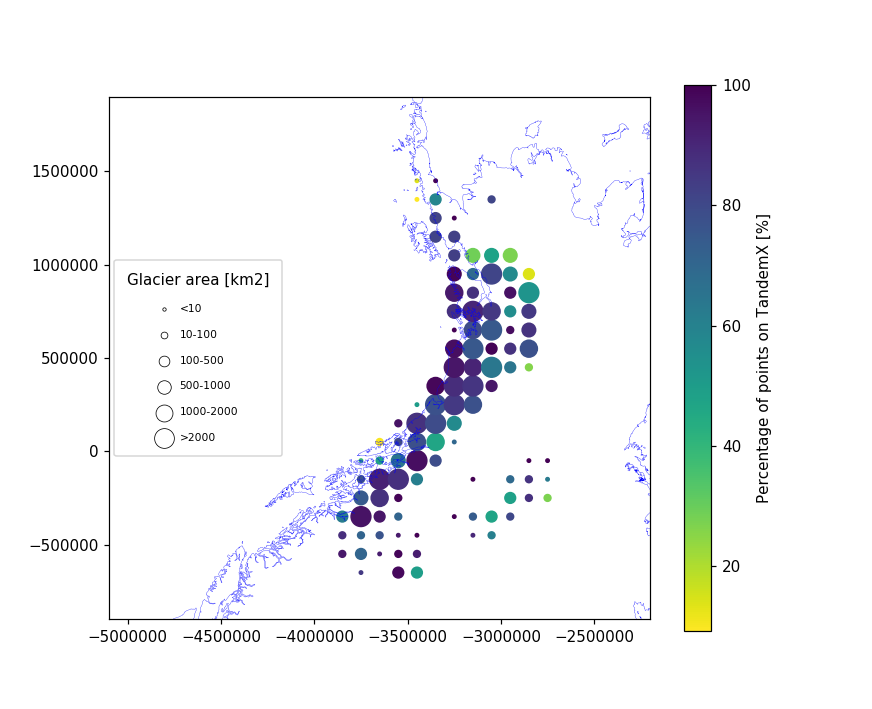

(-900000, 1900000)

In [52]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,6.5))


# plot rivers and country boundaries
#countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
#rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)
coastline.plot(ax=ax, color='blue', edgecolor=None, linewidth=0.2)

cmap='viridis_r'
vmin=dfStats['statistics.pointsOnDataSetValue2Ratio'].min()
vmax=dfStats['statistics.pointsOnDataSetValue2Ratio'].max()

markersize = dfStats['statistics.GlacierMaskArea.pointsize']
plot = dfStats.plot(ax=ax, column='statistics.pointsOnDataSetValue2Ratio', markersize=markersize, cmap=cmap, \
                   vmin=vmin, vmax=vmax)

labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [5, 20, 50, 80, 125, 170]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

bar=fig.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap))
bar.set_label('Percentage of points on TandemX [%]')
    
plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 6, borderpad = 1.2,\
handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)

plt.xlim(-5100000, -2200000)
plt.ylim(-900000, 1900000)

#for i, txt in enumerate(dfStats['statistics.result_total']):
#    ax.annotate(int(txt), (dfStats.loc[dfStats.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStats.loc[dfStats.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


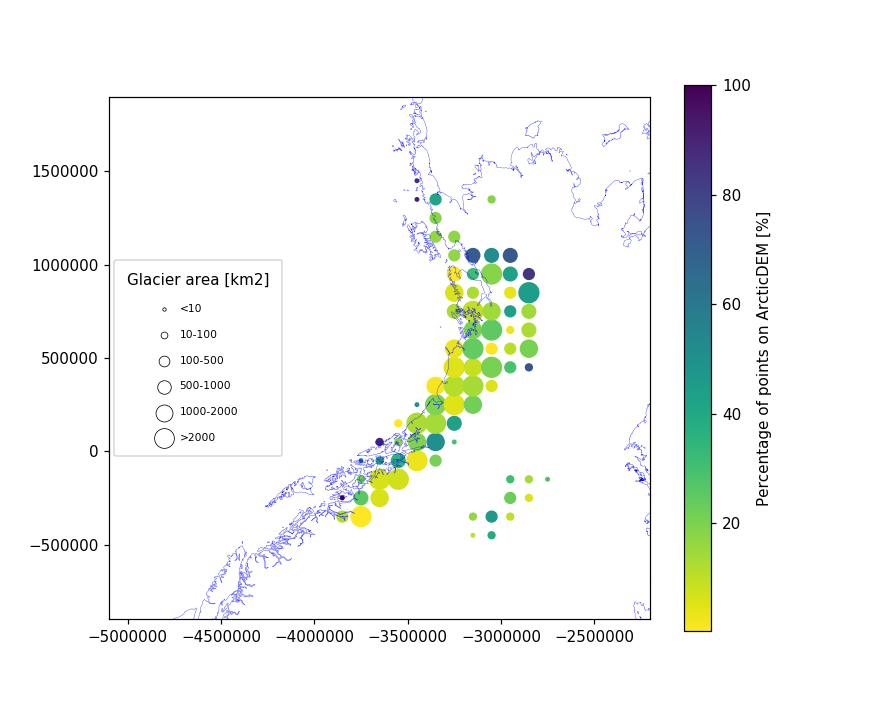

(-900000, 1900000)

In [53]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,6.5))


# plot rivers and country boundaries
#countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
#rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)
coastline.plot(ax=ax, color='blue', edgecolor=None, linewidth=0.2)

cmap='viridis_r'
vmin=dfStats['statistics.pointsOnDataSetValue1Ratio'].min()
vmax=dfStats['statistics.pointsOnDataSetValue1Ratio'].max()

markersize = dfStats['statistics.GlacierMaskArea.pointsize']
plot = dfStats.plot(ax=ax, column='statistics.pointsOnDataSetValue1Ratio', markersize=markersize, cmap=cmap, \
                   vmin=vmin, vmax=vmax)

labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [5, 20, 50, 80, 125, 170]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

bar=fig.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap))
bar.set_label('Percentage of points on ArcticDEM [%]')
    
plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 6, borderpad = 1.2,\
handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)

plt.xlim(-5100000, -2200000)
plt.ylim(-900000, 1900000)

#for i, txt in enumerate(dfStats['statistics.result_total']):
#    ax.annotate(int(txt), (dfStats.loc[dfStats.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStats.loc[dfStats.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


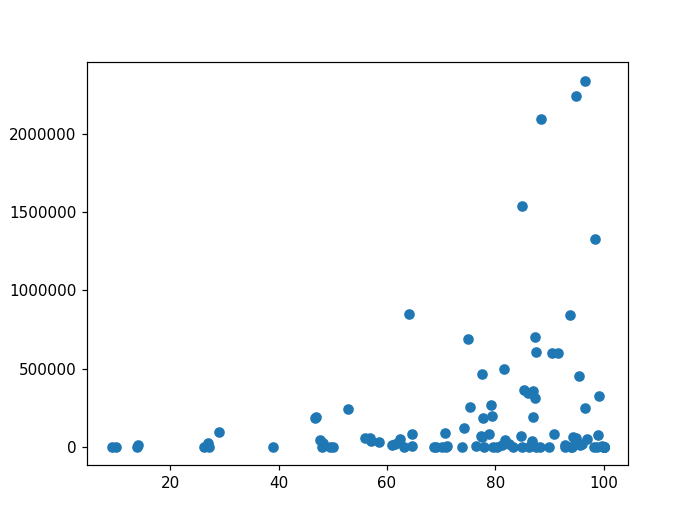

In [54]:
%matplotlib notebook
plt.scatter(x=dfStats['statistics.pointsOnDataSetValue2Ratio'], y=dfStats['statistics.result_total'])